# Non Local means for image denoising

This practical session explains how to implement the [Non local means algorithm](https://epubs.siam.org/doi/pdf/10.1137/040616024?casa_token=T_quJzhNoP8AAAAA:JYmsToAmRuk_jyIaLUEpwQqlmu5rCCB_j49qFTrhCchWUE2RgFC8SWsh5i-yEVnrNd1GTt5f29HClw) for denoising images, introduced in 2005 by Buadès, Coll and Morel in 

 - Buades, A., Coll, B., & Morel, J. M. (2005). *A review of image denoising algorithms, with a new one*. Multiscale modeling & simulation, 4(2), 490-530.

## Underlying Principle

Assume that we observe a noisy $n \times n$ image $v = u + b,$ with $b$ an additive Gaussian noise (assumed to be i.i.d  $\sim \mathcal{N}$(0,$\sigma^2$)). Our goal is to recover the unknown image $u$ from the knowledge of $v$.

Consider a pixel $i$ of $v$, we write $v_i$ the value of $v$ at location $i$. If we had not only $v$, but several independent noisy versions of $u$, we could compute the average of all these versions to recover $u$ (since the noise is centered). In practice, we have access to a single noisy version $v$.

However, this idea can be used by exploiting the patch redundancy of natural images. Patches are small image pieces, typically squares of size $D\times D$ extracted from an image. For each image patch, it's very likely that geometrically similar patches might be found somewhere else in a neighborhood around it. We can average these similar patches to denoise their pixels. 

The NLmeans (**Non-Local Means Denoising**) algorithm uses weights to balance the importance of the different patches in this average.
More formally, for each pixel $i$, the NLmeans computes at $i$ the value 

$$
NL(v)_i = 
    \frac {\sum_{j \in \mathcal{N}(i)} w_{i,j} v_j} 
          {\sum_{j \in \mathcal{N}(i)} w_{i,j}}
$$

with $\mathcal{N}(i)$ is a (predefined) neighborhood of $i$, and $w_{i,j}$ are weights measuring the similarity between patches centered at $i$ and $j$, typically:

$$
w_{i,j} = e ^ -
    \frac {\left\| x_i - x_j \right\|^2_2} 
          {2h^2}
$$

with $x_i$ the patch (a $D\times D$ square) of $v$ centered at $i$, and $h$ a constant parameter to control the patch difference. 

References: 
* https://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf
* https://docs.opencv.org/4.x/d5/d69/tutorial_py_non_local_means.html



## Importing Packages ##

Below is a list of the packages needed to implement Non Local Means denoising.

* `matplotlib.pyplot, BytesIO, urlopen` (load and display images)
* `integral_image` (to compute integral images)
* `time` (to measure time spend on the algorithms)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO                 # used for importing online images 
from urllib.request import urlopen     # used for importing online images 
import time
%matplotlib inline

## Loading image and create noisy version
Start by creating the noisy image $v$ by adding a Gaussian noise image to a known image $u$. We will work with a small image at first, because the naive implementation of NLmeans, using several 'for' loops, is computationnally very expansive on a CPU.

In [2]:
# Noise standard deviation
sigma = 15/255

# Read image
IMG = "https://raw.githubusercontent.com/luciabouzaheguerte/Images/main/simpson.png"
fullimage = plt.imread(BytesIO(urlopen(IMG).read()))

# Extract a crop  
u = fullimage[100:200, 100:200]                                       # crop
     
# Add noise
nrow,ncol = u.shape
b = sigma*np.random.randn(nrow,ncol)
v = u + b                                         

Display both images:

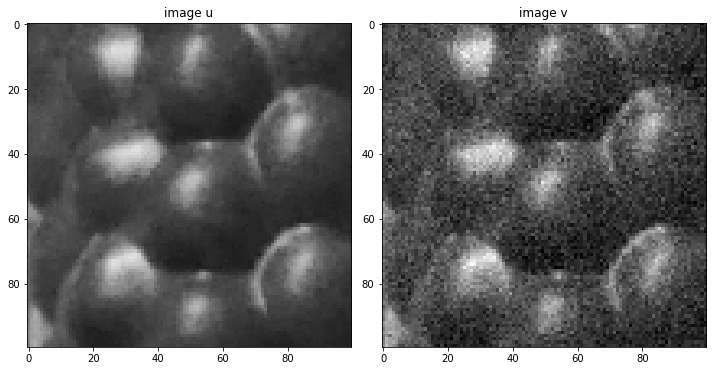

In [3]:
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

# Display image u and noisy image v
printImages(u, v, 'image u', 'image v', 10, 10)

## Measure Performance

In the following, we will compare several implementations of the algorithm, in terms of computing time and performance. We will use the PSNR (defined below) to measure this performance. The higher the value, the better the result.

In [4]:
def PSNR(image_u, image_denoised, peak=1):
    
    return 10*np.log10(peak**2/np.mean((image_u-image_denoised)**2))

print("PSNR: ", PSNR(u, v))

PSNR:  24.562579625424416


Also we will define raise and error if we have underflow or other problems with numpy calculations:

In [5]:
np.seterr('raise') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Naive NLmeans Algorithm

The naive implementation of NLmeans combines several 'for' loops on image pixels: 
* Loop over each pixel $p$ of the image  (of size $N \times N$)
    * Loop over all pixels $q$ in the neighborhood of $p$ (size $W \times W$) 
        * compute the distance between patches (of size $D \times D$) centered at $p$ and $q$
        * compute weights 
        * compute the weighted mean and denoise the current pixel $p$

This naive algorithm has an overall complexity of $O(N^2W^2D^2)$, which results in prohibitive computing times for standard images.

### Implementation

Some remarks about the implementation of the algorithm:
  * We weight the pixel $p$ itself with the highest weight computed for the pixels of the neighborhood. If we do not, the central pixel has a weight which is too important in the average. 
  * In order to denoise pixels near the 4 image borders, we pad the image symmetrically. We unpad at the end of the algorithm. 


In [6]:
def nl_means_naive(image_orig, s_patch, d_neig, h):

    n_row, n_col = image_orig.shape[0], image_orig.shape[1]
    offset = int(s_patch / 2)

    # Pad image by symmetry to be able to denoise the border pixels
    image = np.pad(image_orig, ((offset, offset), (offset, offset)), mode = 'symmetric')

    # Initialize the image to return
    image_denoised = np.zeros_like(image)
  
    # Loop over each pixel of the original image
    for row in range(offset, n_row + offset):
        for col in range(offset, n_col + offset):

            # Define neighborhood limits
            i_start = max(0, row - d_neig)
            i_end = min( image.shape[0] -1, row + d_neig +1)
            j_start = max(0, col - d_neig)
            j_end = min(image.shape[1] -1, col + d_neig +1)

            totalweight = 0
            weight_max = 0

            # Loop over core pixels of the neighborhood to compute distances between patches
            for i in range(i_start + offset, i_end - offset):
                for j in range(j_start + offset, j_end - offset):
                    if(i != row and j != col):     # all pixels except the current one     
              
                        # Compute distance between patches
                        d = np.sum((image[i - offset:i + offset +1, j - offset:j + offset +1] - image[row - offset:row + offset+1, col - offset:col + offset +1])**2)
                        w = np.exp(-d/(2 * h**2))  # weight
                        # Intermidiates values for  mean
                        image_denoised[row, col] += w * image[i,j]
                        totalweight += w
                        # Update weight_max
                        if w > weight_max:
                            weight_max = w
      
            # For the pixel ifself
            image_denoised[row, col] += weight_max * image[row,col]
            totalweight += weight_max  
      
            # If no patch is similar, totalweight will be 0. leave the same pixel. 
            if totalweight == 0: 
                image_denoised[row, col] = image[row, col]
            # Else compute the mean
            else: 
                image_denoised[row, col] /= totalweight

    # Unpad de image
    return  np.squeeze(np.asarray(image_denoised[offset: -offset, offset: -offset]))

Let's try the algorithm, while measuring the time spent and performance. 

The algorithm might run for a few dozens of seconds (for a 100x100 image) so be patient! 

time:  56.45383620262146
PSNR:  31.137845903061525


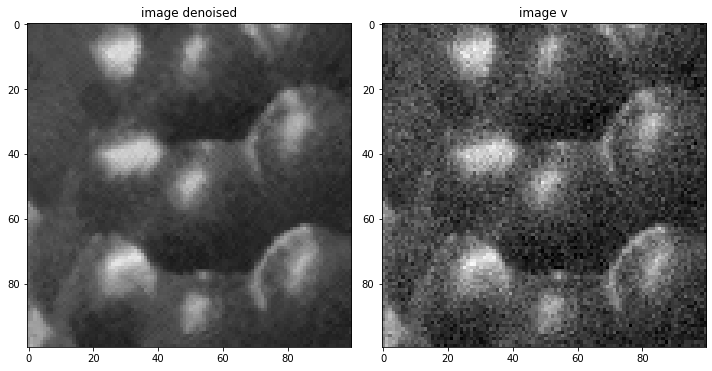

In [7]:
start = time.time()
image_denoised = nl_means_naive(v, 3, 10, 2*sigma)
end = time.time()

# Display results
print("time: ", end - start)
print("PSNR: ", PSNR(u, image_denoised))
printImages(image_denoised, v, 'image denoised', 'image v', 10, 10)

In this naive version, we see that distance computations between two pixels are done $D^2$ times, since these two pixels belong to $D^2$ patches. This can be avoided by using integral images, as we will see in the following. 

## 2. NLmeans with integral Images

In order to reduce drastically the number of computations, we will use what is called Integral images. The goal is to loop only on all the possible shifts in the $W\times W$ neighborhood. To this aim, we will first write a shift function which takes the whole image and create a new one, of the same size, but shifted by a vector $(dx,dy)$. Pixels left empty after the shift are filled by zeros. 



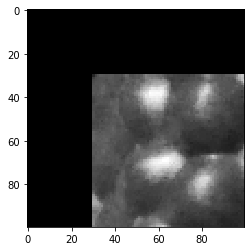

In [8]:
def img2DShift(v,dx,dy):
    # create an image of the same size as v, containing v shifted by (dx,dy) 
    vt = np.zeros_like(v)
    n_row, n_col = v.shape
    
    type = (dx>0)*2+(dy>0)
    if(type==0):
          vt[-dx:n_row,-dy:n_col] = v[0:n_row+dx,0:n_col+dy]
    elif(type==1): 
            vt[-dx:n_row,0:n_col-dy] = v[0:n_row+dx,dy:n_col]
    elif(type==2): 
            vt[0:n_row-dx,-dy:n_col] = v[dx:n_row,0:n_col+dy]
    else: 
            vt[0:n_row-dx,0:n_col-dy] = v[dx:n_row,dy:n_col]
    return vt 

# Let's try with a (-30,-30) shift
plt.imshow(img2DShift(u,-30,-30), cmap='gray')

### Integral images. 
The Integral image of an image $u$ is an image of the same size as $u$, obtained by summing cumulatively, from left to right and top to bottom, all the values of pixels of $u$.  

This integral image can be computed by using 'np.cumsum' first on lines and then on columns. 

###How integral images helps us to compute distances between patches?

Once the integral image of an image $u$ is computed, the sum of values of $u$ in any rectangular region can be obtained in $O(1)$ by combining the four values at the corners of this rectangular region in the corresponding integral image. Suppose we want to compute the sum on the black region in the following figure. If A is the value of the integral image on the Bottom_right corner, C on the top_right corner, D on the bottom_left and V on the top_left corner, then we just compute

 `A - C - D + B`

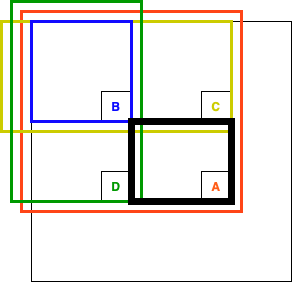

We will use this integral image trick on an image containing squared distance between values of $u$ and values of $u$ shifted by $(dx,dy)$. This will permit to have a quick access to distances between all pair of patches shifted by $(dx,dy)$ from one another. This is the goal of the following function

In [9]:
def integralImgSqDiff(v,dx,dy):
  # compute a map of distances between pair of patches shifted by (𝑑𝑥,𝑑𝑦) in v    
    vt = img2DShift(v,dx,dy)
    diff = (v-vt)**2
    squarediff = np.cumsum(np.cumsum(diff,axis=0),axis=1)
    return squarediff

### algorithm

The NLmeans algorithm using integral images can be written as follows.

* Loop over each possible shift defined by the neighborhood size ($W \times W$).
   * For the current shift $(dx,dy)$, compute the map of squared distances between all pair of patches shifted by (𝑑𝑥,𝑑𝑦) in v (aprox $N \times N$)
   * Use the previous map to update weights and the weighted mean 

The final algorithm now runs in $O(N^2W^2)$.

References: 
* https://www.ipol.im/pub/art/2014/57/article_lr.pdf
* https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/_nl_means_denoising.pyx


In [10]:
def NLmeans_integral(v, s_patch, d_neig, h):
  # Denoising v thanks to Nlmeans with integral images.  
  #s_patch is the patch size and d_neig the neighborhood half-size. h is the denoising strength.
    offset = int(s_patch / 2)

    nr, nc       = v.shape
    vtmp         = np.zeros_like(v)
    Z            = np.zeros_like(v)
    maxweight     = np.zeros_like(v)
    vpaddedf     = np.pad(v, ((offset, offset), (offset, offset)), mode = 'symmetric') 
    vpaddedt     = np.pad(v, ((d_neig, d_neig), (d_neig, d_neig)), mode = 'symmetric')  
    
    
    # For every possible shift inside a neighborhood
    for dx in range(-d_neig, d_neig + 1):
        for dy in range(-d_neig, d_neig + 1):
      
            if(dx!= 0 and dy!= 0):

                sd = integralImgSqDiff(vpaddedf,dx,dy)
                SqDist = np.zeros_like(v) 
                SqDist[0,0] = sd[2*offset,2*offset] 
                SqDist[0,1:] = sd[2*offset,2*offset+1:] - sd[2*offset,0:nc-1] 
                SqDist[1:,0] = sd[2*offset+1:,2*offset] - sd[0:nr-1,2*offset]        
                SqDist[1:,1:] = sd[2*offset+1:,2*offset+1:]+sd[0:nr-1,0:nc-1]- sd[0:nr-1,2*offset+1:]-sd[2*offset+1:,0:nc-1]      
                
                
                # weight computation
                w = np.exp(-SqDist/(2*(h**2)))   
                maxweight= np.maximum(maxweight,w)
                vs = vpaddedt[(d_neig+dx):(d_neig+dx+nr),(d_neig+dy):(d_neig+dy+nc)]   # size of vs = [nr,nc]
                
                vtmp  = vtmp + w*vs
                Z  = Z+w
            
    # case dx = 0 and dy = 0 (central pixel for each patch)
    vs = vpaddedt[(d_neig):(d_neig+nr),(d_neig):(d_neig+nc)]   # size of vs = [nr,nc]
    vtmp  = vtmp + maxweight*vs
    Z  = Z + maxweight   

    udenoised = vtmp/Z
    return udenoised

Let's try on the same image as the previous naive implementation.

time:  0.22414040565490723
PSNR:  31.147566198039694


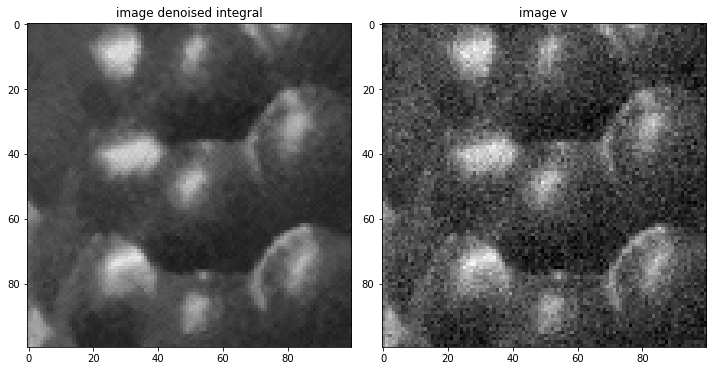

In [11]:
start = time.time()
image_denoised_integral = NLmeans_integral(v, 3, 10, 2*sigma)
end = time.time()

# Display results
print("time: ", end - start)
print("PSNR: ", PSNR(u, image_denoised_integral))
printImages(image_denoised_integral, v, 'image denoised integral', 'image v', 10, 10)

This new version of NLmeans is much faster, so we can run it on a larger image. 

time:  25.273549556732178
PSNR:  33.89001164078084


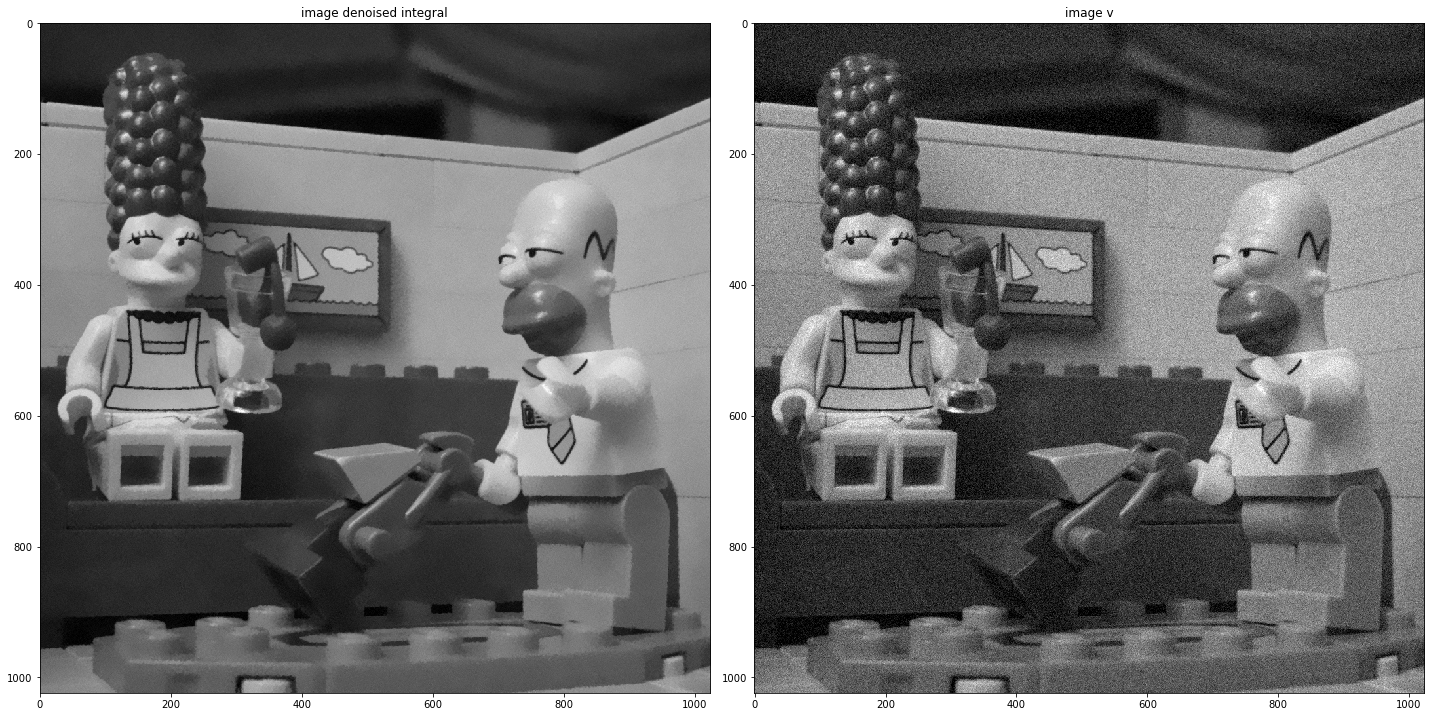

In [12]:
u = fullimage                                    
sigma = 15/255
# Calculate noise
nrow,ncol = u.shape
b = sigma*np.random.randn(nrow,ncol)

v = u + b  

start = time.time()
image_denoised_integral = NLmeans_integral(v, 3, 10, 2*sigma)
end = time.time()

# Display results
print("time: ", end - start)
print("PSNR: ", PSNR(u, image_denoised_integral))
printImages(image_denoised_integral, v, 'image denoised integral', 'image v', 20, 10)

**Questions** 
1. Try to replace the distance between patches in the previous algorithm by a $L^1$ distance, or by $\max(0,\|x_i - x_j\|^2-\sigma^2)$
2. What happens when $h$ decreases or increases ? 
3. Same question with the patch size and the neighborhood size.

## 3. Weight Map

To go further, it is interesting to observe which pixels of the neighborhood are important to denoise a given pixel. We can slightly modify the algorithm above to save the weights of a list of pixels we want to study. 

In [13]:
def NLmeans_integral_weight_map(list_pixels, v, s_patch, d_neig, h):
  # Denoising v thanks to Nlmeans with integral images.  
  #s_patch is the patch size and d_neig the neighborhood half-size. h is the denoising strength.
    offset = int(s_patch / 2)

    nr, nc       = v.shape
    vtmp         = np.zeros_like(v)
    Z            = np.zeros_like(v)
    maxweight     = np.zeros_like(v)
    vpaddedf     = np.pad(v, ((offset, offset), (offset, offset)), mode = 'symmetric') 
    vpaddedt     = np.pad(v, ((d_neig, d_neig), (d_neig, d_neig)), mode = 'symmetric')  
    
    ### Section ADDED #####
    # This list contain the index of pixels on list_pixels and the weight map
    list_weights_maps = np.zeros((len(list_pixels), nr, nc))
    ### End section ADDED #####
    
    # For every possible shift inside a neighborhood
    for dx in range(-d_neig, d_neig + 1):
        for dy in range(-d_neig, d_neig + 1):
      
            if(dx!= 0 or dy!= 0):

                sd = integralImgSqDiff(vpaddedf,dx,dy)
                SqDist = np.zeros_like(v) 
                SqDist[0,0] = sd[2*offset,2*offset] 
                SqDist[0,1:] = sd[2*offset,2*offset+1:] - sd[2*offset,0:nc-1] 
                SqDist[1:,0] = sd[2*offset+1:,2*offset] - sd[0:nr-1,2*offset]        
                SqDist[1:,1:] = sd[2*offset+1:,2*offset+1:]+sd[0:nr-1,0:nc-1]- sd[0:nr-1,2*offset+1:]-sd[2*offset+1:,0:nc-1]      
                
                
                # weight computation
                w = np.exp(-SqDist/(2*(h**2)))   
                maxweight= np.maximum(maxweight,w)
                vs = vpaddedt[(d_neig+dx):(d_neig+dx+nr),(d_neig+dy):(d_neig+dy+nc)]   # size of vs = [nr,nc]
                
                vtmp  = vtmp + w*vs
                Z  = Z+w

                ### Section ADDED #####
                # Save weight for weight_map
                for [row,col] in list_pixels:
                    ind = list_pixels.index([row,col])
                    list_weights_maps[ind, row + dx , col + dy] = w[row, col]
                ### End section ADDED #####
            
    # case dx = 0 and dy = 0 (central pixel for each patch)
    vs = vpaddedt[(d_neig):(d_neig+nr),(d_neig):(d_neig+nc)]   # size of vs = [nr,nc]
    vtmp  = vtmp + maxweight*vs
    Z  = Z + maxweight   

    udenoised = vtmp/Z
    return udenoised, list_weights_maps

Now, we can check the weight map for any pixel. Let's choose a pixel in a constant region, a pixel close to an object edge, and a last one in a more complex region, to observe the behavior of the weights. We run the algorithm and print the weights associated with those pixels.

time:  0.8465139865875244
PSNR:  32.43872025889591


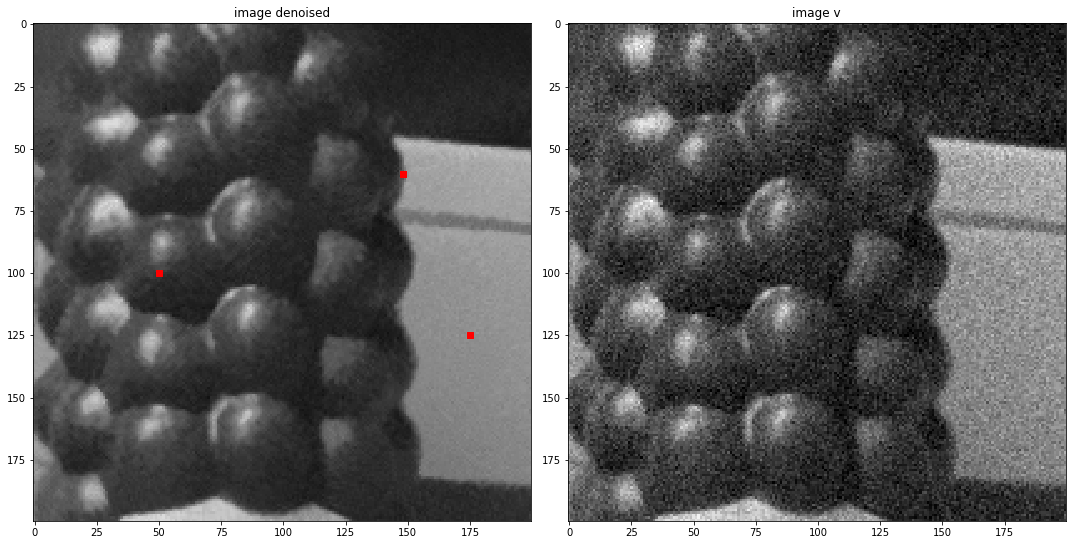

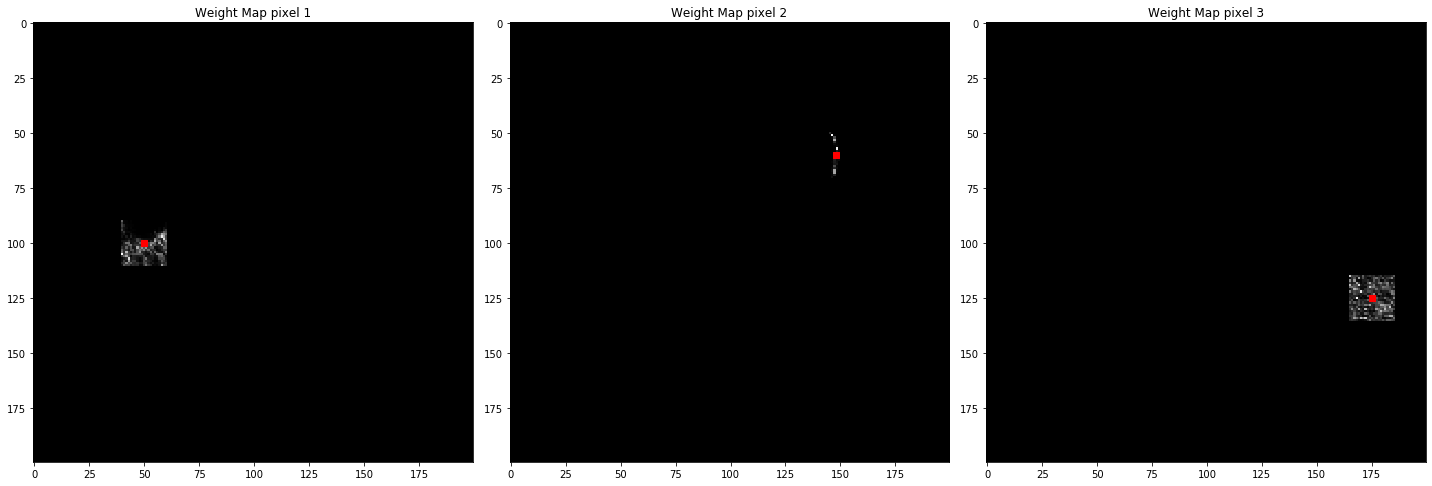

In [14]:
u = fullimage[100:300,100:300]                                     # crop
sigma = 15/255
# Calculate noise
nrow,ncol = u.shape
b = sigma*np.random.randn(nrow,ncol)

v = u + b  
# Pixels we want to study
list_pixels = [[100,50],[60,148], [125,175]]

start = time.time()
image_denoised, list_weights_maps = NLmeans_integral_weight_map(list_pixels,v, 3, 10, 2*sigma)
end = time.time()
print("time: ", end - start)
print("PSNR: ", PSNR(u, image_denoised))

# Print images u and v, and plot selected pixels
aux = np.array(list_pixels)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].set_title('image denoised')
axes[0].imshow(image_denoised,cmap='gray',vmin=0,vmax=1)
axes[0].scatter(aux[:,1], aux[:,0],  c="r", marker=",")
axes[1].set_title('image v')
axes[1].imshow(v,cmap='gray',vmin=0,vmax=1)
fig.tight_layout()
plt.show()

# Print weight map of pixels
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axes[0].set_title('Weight Map pixel 1')
axes[0].imshow(list_weights_maps[0],cmap='gray')
axes[0].scatter(aux[0,1], aux[0,0],  c="r", marker=",") 
axes[1].set_title('Weight Map pixel 2')
axes[1].imshow(list_weights_maps[1],cmap='gray')
axes[1].scatter(aux[1,1], aux[1,0],  c="r", marker=",") 
axes[2].set_title('Weight Map pixel 3')
axes[2].imshow(list_weights_maps[2],cmap='gray')
axes[2].scatter(aux[2,1], aux[2,0],  c="r", marker=",")
fig.tight_layout()
plt.show()

We can see that 
- For pixel 1, pixels on the bright area seems to be discarded from the average. 
- For the second pixel, on the edge of Marge hair, important pixels are those  along the edge. 
- For the third pixel, in a constant region, almost all  pixels on the neighborhood have important weights.

**Questions**
1. Try to compute these edge maps for other pixels, in particuler around singular regions (which do not look to other regions in the image). Wht do you observe? 


## NL means with Pytorch

Now, we will covert the algorithm NL means with integral images, so it can be executed on GPU. We will use Pytorch. 

First, import the needed packages:


* `torch` (indispensables packages using cuda with PyTorch)
* `torchvision.transforms.functional` (necessary to transform images into tensors)
* `pad` to make padding with tensors

In [15]:
import torch
from torchvision.transforms.functional import  to_tensor 
from torch.nn.functional import pad

### Set a device

Next, we need to choose which device to run the algorithm. If we have GPU we will select it. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. Also the `.to(device)` method is used to move tensors or modules to a desired device.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

Device is cuda
Fri Mar 11 21:02:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   25C    P8     8W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     Off  | 00000000:84:00.0 Off |                 

### Rewrite functions

Next we need to rewrite the functions used on NL means with integral images to use Pytorch. As you can see, the algorithm is exactly the same, but we have to change numpy functions to the corresponding ones on Pytorch. Also we need to adjust the sizes of the arrays to the sizes of tensors. 

In [77]:
def img2DShift_gpu(v,dx,dy, device):
    # create an image of the same size as v, containing v shifted by (dx,dy) 
    vt = torch.zeros(v.shape, device=device)
    n_row, n_col = v.shape
    
    type = (dx>0)*2+(dy>0)
    if(type==0):
          vt[-dx:n_row,-dy:n_col] = v[0:n_row+dx,0:n_col+dy]
    elif(type==1): 
            vt[-dx:n_row,0:n_col-dy] = v[0:n_row+dx,dy:n_col]
    elif(type==2): 
            vt[0:n_row-dx,-dy:n_col] = v[dx:n_row,0:n_col+dy]
    else: 
            vt[0:n_row-dx,0:n_col-dy] = v[dx:n_row,dy:n_col]
    return vt 

def integralImgSqDiff_gpu(v,dx,dy, device):
  # compute a map of distances between pair of patches shifted by (𝑑𝑥,𝑑𝑦) in v    
    vt = img2DShift_gpu(v,dx,dy, device)
    diff = (v-vt)**2
    squarediff = torch.cumsum(torch.cumsum(diff,axis=0),axis=1)
    return squarediff


def NLmeans_integral_gpu(v, s_patch, d_neig, h, device):
  # Denoising v thanks to Nlmeans with integral images.  
  #s_patch is the patch size and d_neig the neighborhood half-size. h is the denoising strength.
    offset = int(s_patch / 2)

    nr, nc       = v.shape
    vtmp         = torch.zeros(v.shape, device=device)
    Z            = torch.zeros(v.shape, device=device)
    maxweight    = torch.zeros(v.shape, device=device)
    #vpaddedf     = pad(v[None,None,...], (offset, offset, offset, offset), mode = 'reflect').squeeze()
    #vpaddedt     = pad(v[None,None,...], (d_neig, d_neig, d_neig, d_neig), mode = 'reflect').squeeze()

    #values to calculate outside the loop
    div = -2*(h**2)
    off2 = 2*offset
    
    # For every possible shift inside a neighborhood
    for dx in range(-d_neig, d_neig + 1):
        for dy in range(-d_neig, d_neig + 1):
      
            if(dx!= 0 and dy!= 0):

                sd = integralImgSqDiff_gpu(vpaddedf,dx,dy, device)
                SqDist = torch.zeros(v.shape, device=device)
                SqDist[0,0] = sd[off2,off2] 
                SqDist[0,1:] = sd[off2,off2+1:] - sd[off2,0:nc-1]
                SqDist[1:,0] = sd[off2+1:,off2] - sd[0:nr-1,off2]    
                SqDist[1:,1:] = sd[off2+1:,off2+1:] + sd[0:nr-1,0:nc-1] - sd[0:nr-1,off2+1:] - sd[off2+1:,0:nc-1]      
                
                # weight computation
                w = torch.exp(SqDist/div)
                maxweight= torch.maximum(maxweight,w)
                vs = vpaddedt[(d_neig+dx):(d_neig+dx+nr),(d_neig+dy):(d_neig+dy+nc)]   # size of vs = [nr,nc]
                
                vtmp += w*vs
                Z += w
            
    # case dx = 0 and dy = 0 (central pixel for each patch)
    vs = vpaddedt[(d_neig):(d_neig+nr),(d_neig):(d_neig+nc)]   # size of vs = [nr,nc]
    vtmp += maxweight*vs
    Z += maxweight 

    udenoised = vtmp / Z
    return udenoised

Let's try on the same image as the previous version running on CPU.
As we can see, the algorithm has improved it's around 20 times faster than the original.

In [78]:
u = fullimage#[0:256, 0:256]  
sigma = 15/255
# Calculate noise
nrow,ncol = u.shape
b = sigma*np.random.randn(nrow,ncol)
v = u + b

v_tensor = torch.from_numpy(v).to(device)

start = time.time()
image_denoised = NLmeans_integral_gpu(v_tensor, 3, 10, 2*sigma, device)
end = time.time()

# detach tensors
img_den = image_denoised.clone().detach().cpu().squeeze()
v_orig = v_tensor.clone().detach().cpu().squeeze()

#Display results
print("time: ", end - start)
print("PSNR: ", PSNR(u, img_den.numpy()))
printImages(img_den, v_orig, 'image denoised', 'image v', 20, 10)

2
torch.Size([1026, 1026])
1024
1024


KeyboardInterrupt: Interrupted by user